In [1]:
import autograd.numpy as np
from scipy.optimize import root
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import time 

import torch as th
from torch import nn
from stable_baselines3.td3.policies import TD3Policy
from stable_baselines3.sac.policies import SACPolicy  
from stable_baselines3.common.vec_env import VecNormalize
import gymnasium as gym
from gymnasium import spaces

from sb3_contrib import TQC
from stable_baselines3 import TD3, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
from Solve_IVP_NS.rl.callbacks import RewardCallback, CustomMetricsCallback

sizes = 30
plt.rcParams.update({
    'font.size': sizes,
    'axes.titlesize': sizes,
    'axes.labelsize': sizes,
    'xtick.labelsize': sizes,
    'ytick.labelsize': sizes,
    'legend.fontsize': sizes,
    'figure.titlesize': sizes,
    'text.usetex': True,
    'font.family': 'Times',
    # Embed fonts in vector outputs so text is editable
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    # Keep LaTeX preamble minimal to prevent bloat and ensure Times math
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
    # Cleaner default look; we'll style axes explicitly in plotting code
    'axes.grid': False,
})


import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH


In [2]:
from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver
from collections import deque
import math

A = 1.5; w = 50
def perturbation(t): #(|phi(t)| leq L1 and |dot{phi(t)}| leq L2)
    # phi = np.tanh(t) #(L1=1, L2=1))
    phi = A*np.sin(w*t) #(L1=A, L2=A*w)
    return phi

# Gain (K>L1) :
K = 2
eps_sign = 1e-8

Y0 = np.array([0.1])
f = 10*w/(2*np.pi)
dt_max = 1/f#0.1
tmax = 0.5
t_span = (0.0, tmax)

# ----------------------------------------------------------------
# (1) circuit simulation example . . . totally made up no idea realism
# ----------------------------------------------------------------
def FOSM_rhs_smooth(t, Y):
    """
    Smooth right-hand side for the FOSM.
    
    We have:
      dx/dt = - K*sign(x) + phi(t) 
    
    Here we omit the sign terms (i.e. the constraint terms) so that the smooth ODE is:
      dx/dt = phi(t)
    
    The projection will later inject the sign part.
    """
    # External sources (for example, constant values)
    phi = perturbation(t)

    x = Y
    dxdt = phi
    return np.array([dxdt])

# ----------------------------------------------------------------
# (2) Constraint force function for the projection.
# ----------------------------------------------------------------
def con_force(Y_candidate):
    """
      con_forces[0] = -K
    """    
    con_forces = np.zeros_like(Y_candidate)
    con_forces[0] = K
    return con_forces

# ----------------------------------------------------------------
# (3) Set up the custom solver using the projection.
# ----------------------------------------------------------------
def run_FOSM_custom():
    # Initial conditions (currents and capacitor voltage)
    h_initial = 0.001

    # Define the state partition:
    # For a 3D state, we define:
    #   component_slices = [slice(0,1), slice(1,2), slice(2,3)]
    # The user is free to assign friction to any DOF.
    component_slices = [slice(0,1)]

    # For this circuit, we want constraints on the two inductor currents (DOFs 0 and 1) and none on z.
    # Therefore, set rhok as a vector of length 3:
    rhok = np.array([1.0])
    # And explicitly supply constraint_indices:
    constraint_indices = [0]

    # Create the projection with the user-supplied constraint indices.
    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices
    )

    # Configure the implicit equation solver.
    solver_mp = ImplicitEquationSolver(
        method='VI',
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7
    )
    method_mp = CompositeMethod(solver=solver_mp, A=np.eye(Y0.shape[0]))
    system = ODESystem(
        fun=FOSM_rhs_smooth,  # smooth RHS; constraint handled by projection
        y0=Y0,
        method=method_mp,
        adaptive=True,
        component_slices=component_slices,
        atol=1e-8,
        rtol=1e-6,
        verbose = True,
    )
    solver_instance = ODESolver(system, t_span, h_initial)
    t_vals, y_vals, h_vals, fk_vals, solver_info = solver_instance.solve()
    return t_vals, y_vals, fk_vals

# ----------------------------------------------------------------
# (4) Alternate ODE for solve_ivp (with explicit sign terms)
# ----------------------------------------------------------------
def sign_reg(x, eps):
    # return np.tanh(x/eps)
    # return np.sign(x)
    return x/(np.abs(x)+eps)

def FOSM_rhs_with_reg(t, Y, eps):
    phi = perturbation(t)
    x = Y
    dxdt = - K*sign_reg(x, eps) + phi
    return np.array(dxdt)

# ----------------------------------------------------------------
# (5) Full Example: Compare custom solver vs. solve_ivp for FOSM.
# ----------------------------------------------------------------
def example_FOSM():
    # 1) Run custom solver (smooth RHS + projection)
    start_time = time.time()
    t_custom, y_custom, fk_custom = run_FOSM_custom()
    print('Custom time: {:.2f} seconds'.format(time.time() - start_time))

    # Using the regularized sign function defined above:
    start_time = time.time()
    sol_ivp = solve_ivp(
        fun=lambda t, Y: FOSM_rhs_with_reg(t, Y, eps_sign),
        t_span=t_span,
        y0=Y0,
        method='BDF',
        rtol=1e-8,
        atol=1e-6,
        # max_step=1e-3
    )
    if sol_ivp.success==False: print("Success:",sol_ivp.success)
    print('IVP time: {:.2f} seconds'.format(time.time() - start_time))
    return t_custom, y_custom, fk_custom, sol_ivp.t, sol_ivp.y

t_custom, y_custom, fk_custom, sol_ivp_t, sol_ivp_y = example_FOSM()

[adaptive] reject @ t=0.003, E=5.923e+00 ⇒ h -> 2.805e-03
[adaptive] reject @ t=0.003, E=1.804e+00 ⇒ h -> 1.735e-03
[adaptive] reject @ t=0.0065482, E=1.288e+00 ⇒ h -> 1.857e-03
[adaptive] reject @ t=0.0643308, E=5.821e+00 ⇒ h -> 2.538e-03
[adaptive] reject @ t=0.0643308, E=2.133e+00 ⇒ h -> 1.523e-03
[adaptive] reject @ t=0.067416, E=1.560e+00 ⇒ h -> 1.455e-03
Custom time: 1.45 seconds
IVP time: 0.07 seconds
[adaptive] reject @ t=0.0643308, E=5.821e+00 ⇒ h -> 2.538e-03
[adaptive] reject @ t=0.0643308, E=2.133e+00 ⇒ h -> 1.523e-03
[adaptive] reject @ t=0.067416, E=1.560e+00 ⇒ h -> 1.455e-03
Custom time: 1.45 seconds
IVP time: 0.07 seconds


/tmp/ipykernel_24794/3071861332.py:25: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


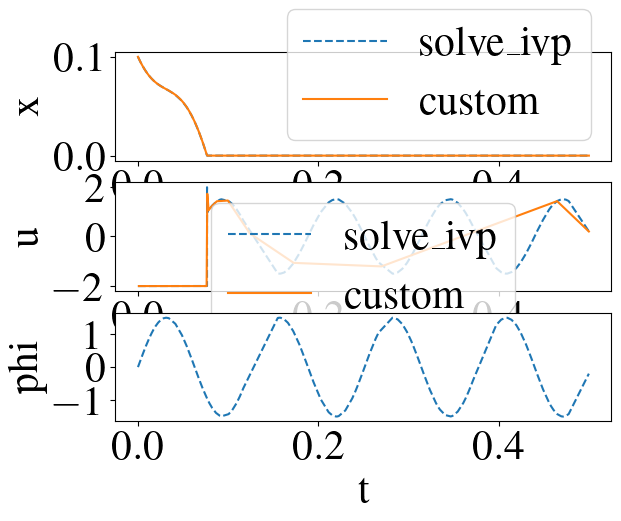

In [3]:
# 3) Plot and compare.
# plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(sol_ivp_t, sol_ivp_y[0, :], '--', label='solve_ivp')
plt.plot(t_custom, y_custom[:, 0], label='custom')
plt.ylabel('x')
plt.xlabel('t')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(sol_ivp_t, -K*sign_reg(sol_ivp_y[0, :],eps_sign), '--', label='solve_ivp')
# plt.plot(t_custom, -K*np.sign(y_custom[:, 0]), label='custom')
plt.plot(t_custom[1:], fk_custom[:, 0], label='custom')
plt.ylabel('u')
plt.xlabel('t')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sol_ivp_t, perturbation(sol_ivp_t), '--', label='solve_ivp')
# plt.plot(t_custom, perturbation(t_custom), '--', label='custom')
plt.ylabel('phi')
plt.xlabel('t')
# plt.legend()

plt.tight_layout()
plt.show()   

In [4]:
# AdaptiveStepperEnv is imported from Solve_IVP_NS.rl.env.
# User-defined reward and observation functions remain below.

In [5]:
# RewardCallback is imported from Solve_IVP_NS.rl.callbacks.

In [6]:
# CustomMetricsCallback is imported from Solve_IVP_NS.rl.callbacks.

In [7]:
import numpy as np
alpha = 2
def my_reward_fn(solver_perf, dt_attempt, xk, env):
    """
    User‐provided reward function.
    Receives:
      - solver_perf: a list containing [runtime, dt, error_LO, error_lil1, error_HI, error,
                          success_LO, success_lil1, success_HI, kiter_LO, iter_lil1, kiter_HI]
      - dt_attempt: the time‐step attempted
      - xk: the current state
      - env: the environment instance (for accessing dt_min, dt_max, etc.)
    """
    runtime_inc, dt, error_LO, error_lil1, error_HI, error, \
        success_LO, success_lil1, success_HI, kiter_LO, iter_lil1, kiter_HI = solver_perf
    if dt == 0:
        reward = - (dt_attempt - env.dt_min) / (env.dt_max - env.dt_min)
    else:
        S1 = (dt - env.dt_min) / (env.dt_max - env.dt_min)
        # Track per-step runtime and update the running maximum to normalize S2 dynamically
        # Initialize runtime history and max on the env if missing
        if not hasattr(env, 'runtime_history'):
            env.runtime_history = []
        env.runtime_history.append(float(runtime_inc))
        # Maintain a running max runtime seen so far
        if not hasattr(env, 'max_runtime_seen'):
            env.max_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc > env.max_runtime_seen:
                env.max_runtime_seen = float(runtime_inc)
        # Compute S2 using the dynamic max; clamp denominator to avoid division by zero
        rt_min = 0.0001
        rt_max = max(rt_min, float(env.max_runtime_seen))
        denom = max(1e-8, rt_max - rt_min)
        S2 = 1 - (float(runtime_inc) - rt_min) / denom
        if S2 < 0:
          print(f'runtime is: {runtime_inc}')
        A = np.exp(-alpha * error)
        reward = S1 * S2 * A
        # print(f'error: {error}, error_term:{A}, runtime:{runtime_inc}, runtime_term:{S2}')

    return reward

def my_obs_fn(dt_attempt, converged, xk, solver_perf,env):
    """
    User‐provided observation function.
    Receives:
      - dt_attempt: the attempted dt (or None on reset)
      - converged: a flag (e.g. 1 if the solver step succeeded, else 0)
      - error: the computed error (E) from the solver step
      - xk: the current state (as passed in by the environment)
      - solver_perf: the full solver performance vector
      - env: the environment instance (for additional parameters)
    Here we return an observation vector that, for example, includes:
      - The friction average (env.fricavg)
      - The average velocity (computed from xk)
      - The normalized iteration error (env.iter_error/4)
      - The convergence flag
      - The normalized error (error/2)
      - The normalized dt_attempt
    (Users can modify this as needed.)
    """

    if dt_attempt is None:
        # For reset, return a default observation.
        # init_ie = xk[0]**2
        x= xk[0]
        x0 = Y0[0]

        ie = 1/2* x**2
        ie0 = 1/2 * x0**2 
        ie_norm = ie/ie0
        x_norm = x/x0
        # avg_v = np.mean(xk[0]) / .1 #user provided vmax and N externally, i.e., not to be handled by the 
        return np.array([ie_norm,x_norm, 1.005, 1., 1., 1.], dtype=np.float64)
    else:
        runtime_inc, dt, error_LO, error_lil1, error_HI, error, \
        success_LO, success_lil1, success_HI, kiter_LO, iter_lil1, kiter_HI = solver_perf
        x= xk[0]
        x0 = Y0[0]

        ie = 1/2* x**2
        ie0 = 1/2 * x0**2 
        ie_norm = ie/ie0
        x_norm = x/x0
        # print(f' iter_error:{env.iter_error},converged:{converged}')

        # avg_v = np.mean(xk[0]) / .1 #extract out the velocity of the state; velocity/initial velocity
        return np.array([ie_norm,x_norm, env.iter_error / 4, converged,
                        np.exp(-alpha * error),
                         (dt_attempt - env.dt_min) / (env.dt_max - env.dt_min)],
                        dtype=np.float64)





Using cuda device
Starting RL training for adaptive time stepping...
Starting RL training for adaptive time stepping...
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 127       |
|    time_elapsed    | 2         |
|    total_timesteps | 292       |
| train/             |           |
|    actor_loss      | 1.28      |
|    critic_loss     | 0.0166    |
|    ent_coef        | 0.995     |
|    ent_coef_loss   | -0.000638 |
|    learning_rate   | 0.0003    |
|    n_updates       | 191       |
|    std             | 0.0499    |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 127       |
|    time_elapsed    | 2         |
|    total_timesteps | 292       |
| train/             |           |
|    actor_loss      | 1.28      |
|    critic_loss     | 0.0166    |
|    ent_coef        | 0.995     |
|    

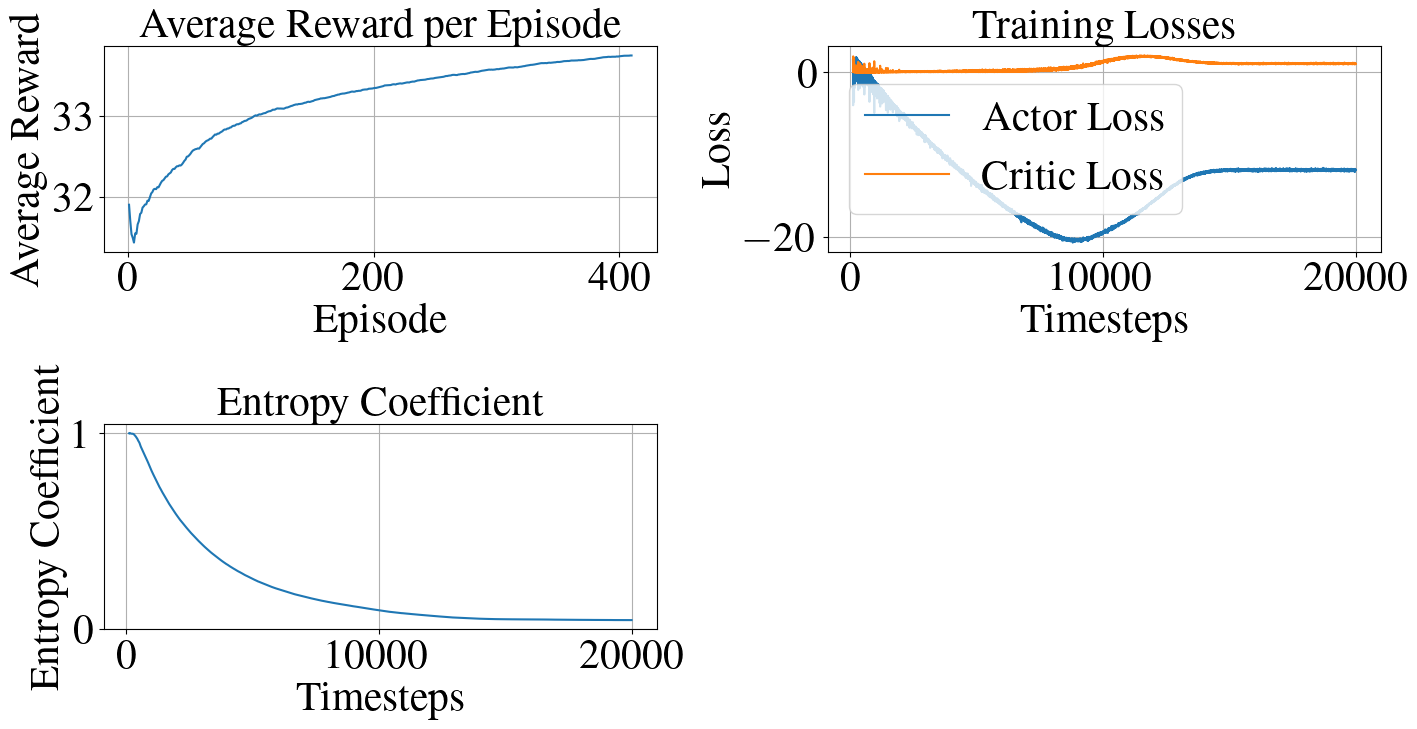

Training time: 197.39 seconds


In [8]:
# --- Example: FOSM Projection ---


def example_FOSM_and_RL():


    # Constraint force function: returns friction only for the velocity DOF.
    def con_force(y):
        con_forces = np.zeros_like(y)
        con_forces[0] = K
        return con_forces

    # ODE system: [velocity, position]
    def FOSM_rhs(t, y):
        phi = perturbation(t)
        x = y
        dxdt = phi
        return np.array([dxdt])

    h_initial = 0.001

    # Component slices (each DOF separately) and constraint indices (only DOF 0 is constrained)
    component_slices = [slice(0, 1)]
    constraint_indices = [0]
    # For constrained DOF 0 we set rhok=1.0; unconstrained DOF 1 gets 0.
    rhok = np.array([1.0])

    # Create the projection operator
    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices
    )

    # Configure the implicit solver (using the VI method here)
    solver_mp = ImplicitEquationSolver(
        method='VI',
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7
    )

    # Use the composite method (which calls the solver internally)
    method_mp = CompositeMethod(solver=solver_mp)

    # --- Now set up the RL training for adaptive time stepping ---
    #
    # Here we build a custom Gym environment where the agent’s action (a number in [0,1])
    # is mapped to a time step in [dt_min, dt_max]. The environment performs one integration step
    # using our composite method and returns an observation (state, dt, error, etc.) and a reward.
    #
    dt0 = 0.01
    t0 = t_span[0]
    tnmax = t_span[1]
    dt_min = 0.001
    f = 10.0*w/(2*np.pi)
    dt_max = 1/f #0.1
    nparams = (1e-6, 500)

    # Define the observation space (here we use the 3 state variables plus 3 extra features regarding solver performance)
    obs_dim = 6
    obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float64)

    # Instantiate the adaptive-stepper environment
    env = AdaptiveStepperEnv(
        system=FOSM_rhs,
        dt0=dt0,
        t0=t0,
        x0=Y0.copy(),
        tnmax=tnmax,
        dt_min=dt_min,
        dt_max=dt_max,
        nparams=nparams,
        integrator=method_mp,
        component_slices=component_slices,
        reward_fn=my_reward_fn,
        obs_fn=my_obs_fn,
        obs_space=obs_space,
        verbose=False
    )

    # Wrap the environment in a vectorized wrapper and normalization (from stable-baselines3)
    vec_env = DummyVecEnv([lambda: env])
    vec_env = VecNormalize(vec_env, norm_obs=False, norm_reward=False)

    # Set up the RL algorithm (here we use TQC)
    policy_kwargs = dict(
        activation_fn=th.nn.ReLU,
        net_arch=dict(pi=[64, 64], qf=[64, 64, 64])
    )
    reward_callback = RewardCallback()
    callback = CustomMetricsCallback()
    model = TQC("MlpPolicy", vec_env, batch_size=256, use_sde=True, verbose=1, policy_kwargs=policy_kwargs)

    print("Starting RL training for adaptive time stepping...")
    start_time = time.time()
    model.learn(total_timesteps=20000, callback=[callback])
    print('Training time: {:.2f} seconds'.format(time.time() - start_time))
    # # Plot reward vs RL timesteps after training
    # plt.figure(figsize=(8, 4))
    # plt.semilogx(reward_callback.timesteps, reward_callback.reward_history, marker='o', linestyle='-')
    # plt.xlabel("Timesteps")
    # plt.ylabel("Reward")
    # # plt.title("Reward vs RL Timesteps")
    # plt.grid(True)

    # plt.savefig("Images/FOSM_TRAINING.pdf")
    # callback.on_training_end()

    # Save the trained model and environment normalization stats
    model.save("FOSM_TQC_adaptive_timestepping_model_modded_reward")
    vec_env.save("FOSM_vec_normalize_adaptive_timestepping_modded_reward.pkl")


if __name__ == "__main__":
    example_FOSM_and_RL()

Using cuda device
Starting TD3 training for adaptive time stepping...
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 205      |
|    time_elapsed    | 1        |
|    total_timesteps | 216      |
| train/             |          |
|    actor_loss      | -0.99    |
|    critic_loss     | 0.00961  |
|    ent_coef        | 0        |
|    learning_rate   | 0.001    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 205      |
|    time_elapsed    | 1        |
|    total_timesteps | 216      |
| train/             |          |
|    actor_loss      | -0.99    |
|    critic_loss     | 0.00961  |
|    ent_coef        | 0        |
|    learning_rate   | 0.001    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps    

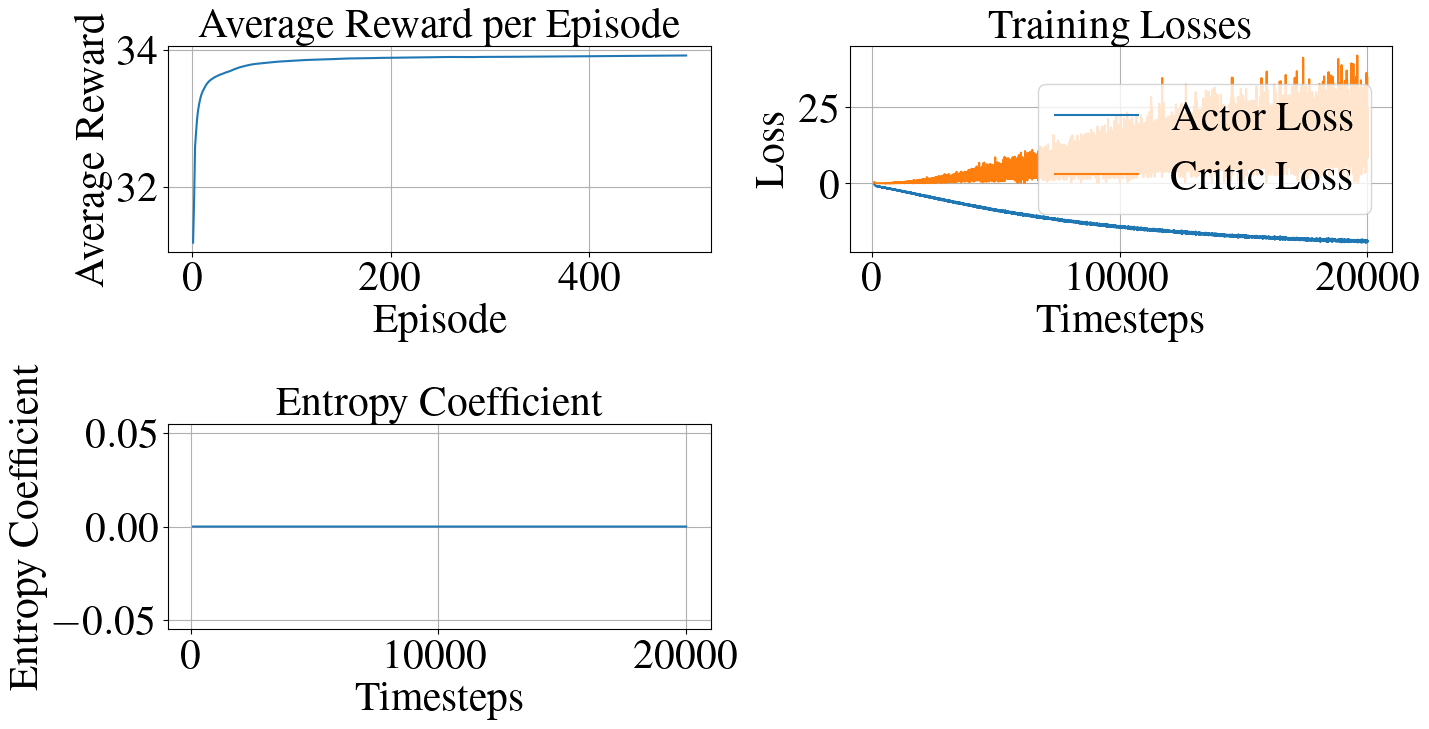

TD3 training time: 127.90 seconds
Saved TD3 model and VecNormalize stats.


In [9]:
# --- TD3 training with the same env/time-step settings as the TQC cell ---
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.env_util import DummyVecEnv
from gymnasium import spaces

# Build the exact same environment as in the TQC training cell
def _build_env_for_td3():
    def con_force(y):
        con_forces = np.zeros_like(y)
        con_forces[0] = K
        return con_forces

    def FOSM_rhs(t, y):
        phi = perturbation(t)
        x = y
        dxdt = phi
        return np.array([dxdt])

    h_initial = 0.001
    component_slices = [slice(0, 1)]
    constraint_indices = [0]
    rhok = np.array([1.0])

    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices,
    )

    solver_mp = ImplicitEquationSolver(
        method='VI',
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7,
    )

    method_mp = CompositeMethod(solver=solver_mp)

    # Match the TQC cell step-size settings exactly
    dt0 = 0.01
    t0 = t_span[0]
    tnmax = t_span[1]
    dt_min = 0.001
    f_local = 10. * w / (2 * np.pi)
    dt_max_local = 1 / f_local
    nparams = (1e-6, 500)

    obs_dim = 6
    obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float64)

    env = AdaptiveStepperEnv(
        system=FOSM_rhs,
        dt0=dt0,
        t0=t0,
        x0=Y0.copy(),
        tnmax=tnmax,
        dt_min=dt_min,
        dt_max=dt_max_local,
        nparams=nparams,
        integrator=method_mp,
        component_slices=component_slices,
        reward_fn=my_reward_fn,
        obs_fn=my_obs_fn,
        obs_space=obs_space,
        verbose=False,
    )
    return env

# Vectorize and normalize, same as TQC
vec_env_td3 = DummyVecEnv([_build_env_for_td3])
vec_env_td3 = VecNormalize(vec_env_td3, norm_obs=False, norm_reward=False)

# TD3 with same network size as TQC
policy_kwargs = dict(
    activation_fn=th.nn.ReLU,
    net_arch=dict(pi=[64, 64], qf=[64, 64, 64])
)
model_td3 = TD3("MlpPolicy", vec_env_td3, verbose=1, policy_kwargs=policy_kwargs)

print("Starting TD3 training for adaptive time stepping...")
start_time = time.time()
callback_td3 = CustomMetricsCallback()
model_td3.learn(total_timesteps=20000, callback=[callback_td3])
print('TD3 training time: {:.2f} seconds'.format(time.time() - start_time))

# Save TD3 model and corresponding VecNormalize stats
model_td3.save("FOSM_TD3_adaptive_timestepping_model_modded_reward")
vec_env_td3.save("FOSM_vec_normalize_adaptive_timestepping_model_modded_reward_td3.pkl")
print("Saved TD3 model and VecNormalize stats.")

In [10]:
# import torch

# print("CUDA available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("CUDA version:", torch.version.cuda)
#     print("Device name:", torch.cuda.get_device_name(0))

# # SB3 model device
# print("Model device:", model.device)  # e.g. cuda:0 or cpu

# # Make 100% sure the policy params live on GPU:
# print("Policy param device:", next(model.policy.parameters()).device)


In [11]:
from pathlib import Path

A = 1.75
w = 50

MODEL_PATH = Path("FOSM_TQC_adaptive_timestepping_model_modded_reward.zip")
VECNORM_PATH = Path("FOSM_vec_normalize_adaptive_timestepping_modded_reward.pkl")
RESULTS_PATH = Path("rl_results.npz")

def make_custom_env():
    # Constraint force function: returns friction only for the velocity DOF.
    def con_force(y):
        con_forces = np.zeros_like(y)
        con_forces[0] = K
        return con_forces

    # ODE system: [velocity, position]
    def FOSM_rhs(t, y):
        phi = perturbation(t)
        x = y
        dxdt = phi
        return np.array([dxdt])

    h_initial = 0.001

    # Component slices (each DOF separately) and constraint indices (only DOF 0 is constrained)
    component_slices = [slice(0, 1)]
    constraint_indices = [0]
    # For constrained DOF 0 we set rhok=1.0; unconstrained DOF 1 gets 0.
    rhok = np.array([1.0])

    # Create the projection operator
    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices
    )

    # Configure the implicit solver (using the VI method here)
    solver_mp = ImplicitEquationSolver(
        method='VI',
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7
    )

    # Use the composite method (which calls the solver internally)
    method_mp = CompositeMethod(solver=solver_mp)

    # --- Adaptive time stepping environment configuration ---
    dt0 = 0.01
    t0 = t_span[0]
    tnmax = t_span[1]
    dt_min = 0.001
    f = 10.0 * w / (2 * np.pi)
    dt_max = 1 / f
    nparams = (1e-6, 500)

    # Define the observation space (here we use the 3 state variables plus 3 extra features regarding solver performance)
    obs_dim = 6
    obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float64)

    # Create the custom environment
    env = AdaptiveStepperEnv(
        system=FOSM_rhs,
        dt0=dt0,
        t0=t0,
        x0=Y0.copy(),
        tnmax=tnmax,
        dt_min=dt_min,
        dt_max=dt_max,
        nparams=nparams,
        integrator=method_mp,
        component_slices=component_slices,
        reward_fn=my_reward_fn,
        obs_fn=my_obs_fn,
        obs_space=obs_space,
        verbose=False
    )
    return env

def load_trained_policy(model_path=MODEL_PATH, vecnorm_path=VECNORM_PATH):
    """Restore VecNormalize statistics and the trained TQC policy for evaluation."""
    vec_env = make_vec_env(make_custom_env, n_envs=1)
    vec_env = VecNormalize.load(str(vecnorm_path), vec_env)
    vec_env.training = False
    vec_env.norm_reward = False
    vec_env.norm_obs = False
    model = TQC.load(str(model_path), env=vec_env)
    return vec_env, model

vec_env, model = load_trained_policy()

obs = vec_env.reset()
print('initial observation:', obs)
done = False
tts = []
xxs = []
fks = []
start_time = time.time()

while not done:
    # Predict the action using the trained model
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)

    if isinstance(info, list):
        info = info[0]  # Access the first environment's info dictionary

    # Access t_k1 and xk from the info dictionary
    tts.append(info['t_k1'])
    xxs.append(np.asarray(info['xk'], dtype=np.float64).squeeze())
    fks.append(np.asarray(info['residuals'], dtype=np.float64).squeeze())

elapsed = time.time() - start_time
print(f'Rollout wall time: {elapsed:.2f} seconds')

tts = np.insert(np.asarray(tts, dtype=np.float64), 0, 0.0)
xxs = np.insert(np.asarray(xxs, dtype=np.float64), 0, np.asarray(Y0, dtype=np.float64).squeeze())
fks = np.insert(np.asarray(fks, dtype=np.float64), 0, -K)

np.savez(RESULTS_PATH, tts=tts, xxs=xxs, fks=fks)
print(f"Saved rollout statistics to '{RESULTS_PATH}'")

initial observation: [[1.    1.    1.005 1.    1.    1.   ]]
Rollout wall time: 0.19 seconds
Saved rollout statistics to 'rl_results.npz'
Rollout wall time: 0.19 seconds
Saved rollout statistics to 'rl_results.npz'


### Evaluating the trained controller
Once the rollout cell finishes, `rl_results.npz` stores the sampled time grid (`tts`), state trajectory (`xxs`), and projection forces (`fks`). The plotting cells below can be re-run without modification to compare the learned controller against the analytical and heuristic baselines.

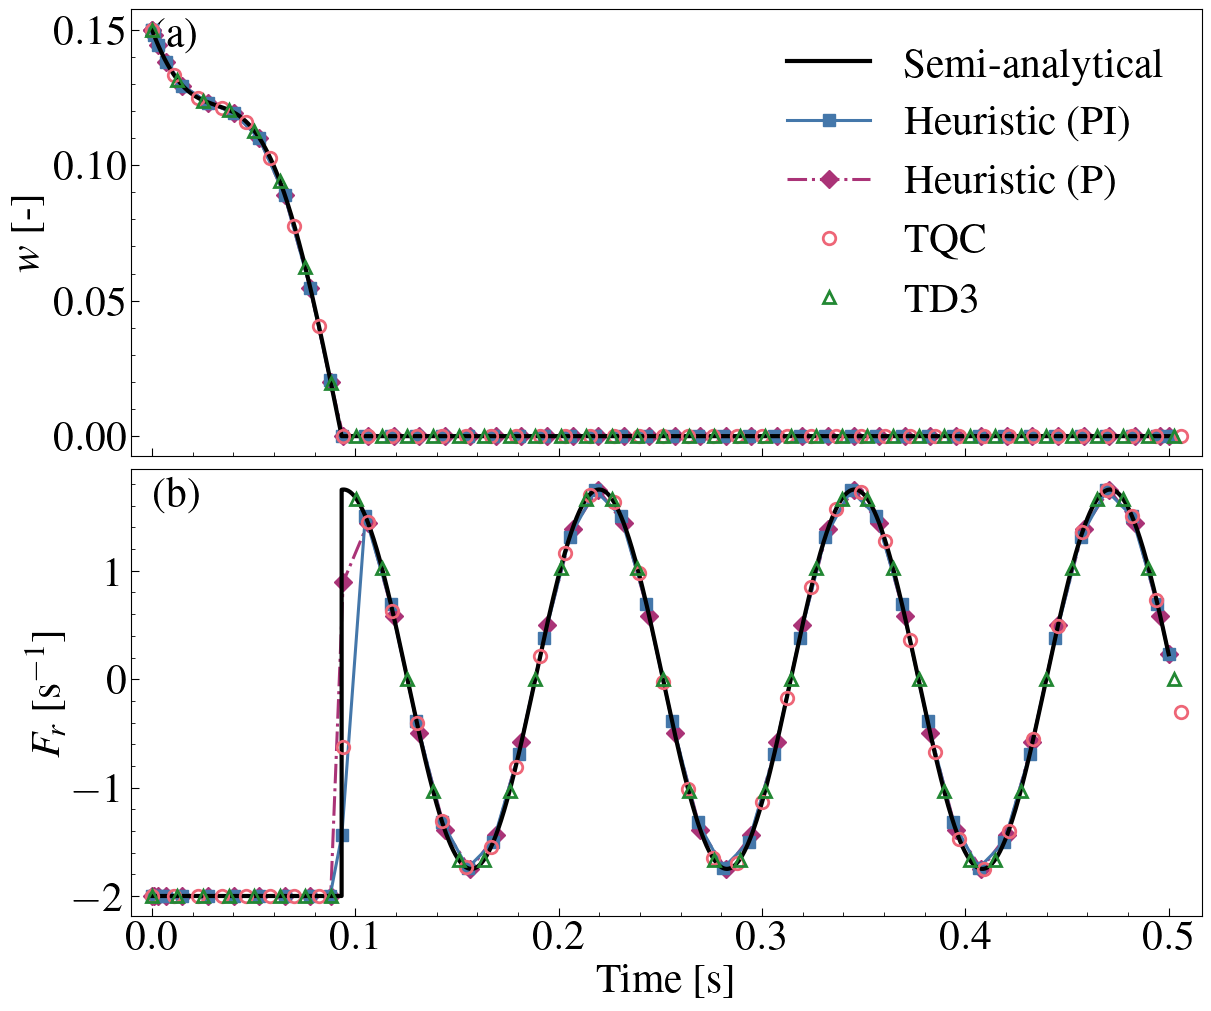

Comparison figure saved to Images/control_state_comparison.pdf and Images/control_state_comparison.png

Average run times over 10 runs:
------------------------------------------
Method                    Average time (s)
------------------------------------------
Heuristic (PI)                       0.282
Heuristic (P)                        0.243
TQC                                  0.161
TD3                                  0.159
------------------------------------------


In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import brentq

from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3 import TD3
from sb3_contrib import TQC

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
A = 1.75
w = 50
K = 2
eps_sign = 1e-8

Y0 = np.array([0.15])
tmax = 0.5
t_span = (0.0, tmax)
f = 10.0 * w / (2 * np.pi)
dt_max = 1 / f

BASE_DIR = Path('.')
RESULTS_DIR = BASE_DIR
PLOTS_DIR = BASE_DIR / 'Images'
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Save paths for heuristic (PI) and its P-only variant
CUSTOM_RESULTS_PATH = RESULTS_DIR / 'custom_results.npz'            # PI (existing)
CUSTOM_RESULTS_P_PATH = RESULTS_DIR / 'custom_results_p.npz'       # P-only variant

# RL result paths
RL_RESULTS_TQC_PATH = RESULTS_DIR / 'rl_results_tqc.npz'
RL_RESULTS_TD3_PATH = RESULTS_DIR / 'rl_results_td3.npz'
STATE_PLOT_PDF = PLOTS_DIR / 'control_state_comparison.pdf'
STATE_PLOT_PNG = PLOTS_DIR / 'control_state_comparison.png'
FORCE_PLOT_PDF = PLOTS_DIR / 'control_force_comparison.pdf'
FORCE_PLOT_PNG = PLOTS_DIR / 'control_force_comparison.png'

MODEL_PATH_TQC = BASE_DIR / 'FOSM_TQC_adaptive_timestepping_model_modded_reward.zip'
VECNORM_PATH_TQC = BASE_DIR / 'FOSM_vec_normalize_adaptive_timestepping_modded_reward.pkl'

MODEL_PATH_TD3 = BASE_DIR / 'FOSM_TD3_adaptive_timestepping_model_modded_reward.zip'
VECNORM_PATH_TD3 = BASE_DIR / 'FOSM_vec_normalize_adaptive_timestepping_model_modded_reward_td3.pkl'

RL_EVAL_CONFIGS = [
    {
        'name': 'TQC',
        'model_cls': TQC,
        'model_path': MODEL_PATH_TQC,
        'vecnorm_path': VECNORM_PATH_TQC,
        'results_path': RL_RESULTS_TQC_PATH,
    },
    {
        'name': 'TD3',
        'model_cls': TD3,
        'model_path': MODEL_PATH_TD3,
        'vecnorm_path': VECNORM_PATH_TD3,
        'results_path': RL_RESULTS_TD3_PATH,
    },
]

# Print-friendly, colorblind-safe palette (Paul Tol "bright" set)
COLORS = {
    'analytic': '#000000',  # black
    'pi': '#4477AA',       # strong blue
    'p': '#AA3377',        # purple/magenta (darker than before)
    'tqc': '#EE6677',      # vermillion/red
    'td3': '#228833',      # green
}
MARKERS = {
    'pi': 's',   # square
    'p': 'D',    # diamond
    'tqc': 'o',  # circle
    'td3': '^',  # triangle up
}

# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------
def perturbation(t):
    return A * np.sin(w * t)

def FOSM_rhs_smooth(t, Y):
    phi = perturbation(t)
    return np.array([phi])

def con_force(Y_candidate):
    con_forces = np.zeros_like(Y_candidate)
    con_forces[0] = K
    return con_forces

def run_FOSM_custom(use_PI: bool = True):
    """Run the heuristic solver with PI controller (default) or P-only when use_PI=False."""
    h_initial = 0.001
    component_slices = [slice(0, 1)]
    constraint_indices = [0]
    rhok = np.array([1.0])

    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices,
    )

    solver_mp = ImplicitEquationSolver(
        method='VI',
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7,
    )
    method_mp = CompositeMethod(solver=solver_mp, A=np.eye(Y0.shape[0]))
    system = ODESystem(
        fun=FOSM_rhs_smooth,
        y0=Y0,
        method=method_mp,
        adaptive=True,
        component_slices=component_slices,
        atol=1e-6,
        rtol=1e-3,
    )
    # Configure adaptive stepper bounds and controller mode
    if hasattr(system, 'adaptive_stepper'):
        system.adaptive_stepper.h_min = 0.00001
        system.adaptive_stepper.h_max = dt_max
        system.adaptive_stepper.use_PI = bool(use_PI)
    else:
        print('Adaptive stepper not found on system. Check your ODESystem implementation.')

    solver_instance = ODESolver(system, t_span, h_initial)

    t_vals, y_vals, h_vals, fk_vals, solver_info = solver_instance.solve()
    t_vals = np.asarray(t_vals, dtype=np.float64)
    y_vals = np.asarray(y_vals, dtype=np.float64).reshape(-1)
    fk_vals = np.asarray(fk_vals, dtype=np.float64).reshape(-1)
    return t_vals, y_vals, fk_vals

def make_custom_env():
    component_slices = [slice(0, 1)]
    constraint_indices = [0]
    rhok = np.array([1.0])

    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices,
    )

    solver_mp = ImplicitEquationSolver(
        method='VI',
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7,
    )
    method_mp = CompositeMethod(solver=solver_mp)

    def FOSM_rhs(t, y):
        return np.array([perturbation(t)])

    from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
    from gymnasium import spaces

    dt0 = 0.01
    dt_min = 0.001
    nparams = (1e-6, 500)

    obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float64)

    env = AdaptiveStepperEnv(
        system=FOSM_rhs,
        dt0=dt0,
        t0=t_span[0],
        x0=Y0.copy(),
        tnmax=t_span[1],
        dt_min=dt_min,
        dt_max=dt_max,
        nparams=nparams,
        integrator=method_mp,
        component_slices=component_slices,
        reward_fn=my_reward_fn,
        obs_fn=my_obs_fn,
        obs_space=obs_space,
        verbose=False,
    )
    return env

# -----------------------------------------------------------------------------
# Reward/observation definitions from earlier cells are reused here
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# Benchmark: heuristic PI vs P (solve_ivp baseline removed)
# -----------------------------------------------------------------------------
num_runs = 10

# Heuristic with PI controller (existing default)
pi_total_time = 0.0
for i in range(num_runs):
    start = time.time()
    t_custom_pi, y_custom_pi, fk_custom_pi = run_FOSM_custom(use_PI=True)
    pi_total_time += time.time() - start
avg_custom_time_pi = pi_total_time / num_runs

# Heuristic with P-only controller
p_total_time = 0.0
for i in range(num_runs):
    start = time.time()
    t_custom_p, y_custom_p, fk_custom_p = run_FOSM_custom(use_PI=False)
    p_total_time += time.time() - start
avg_custom_time_p = p_total_time / num_runs

# Save last-run results for both heuristic variants (prepend initial samples for alignment)
t_pi_series = np.insert(t_custom_pi, 0, 0.0).astype(np.float64)
y_pi_series = np.insert(y_custom_pi, 0, Y0[0]).astype(np.float64)
fk_pi_series = np.insert(fk_custom_pi, 0, -K).astype(np.float64)
np.savez(CUSTOM_RESULTS_PATH, t_custom=t_pi_series, y_custom=y_pi_series, fk_custom=fk_pi_series)

t_p_series = np.insert(t_custom_p, 0, 0.0).astype(np.float64)
y_p_series = np.insert(y_custom_p, 0, Y0[0]).astype(np.float64)
fk_p_series = np.insert(fk_custom_p, 0, -K).astype(np.float64)
np.savez(CUSTOM_RESULTS_P_PATH, t_custom=t_p_series, y_custom=y_p_series, fk_custom=fk_p_series)

# -----------------------------------------------------------------------------
# RL-based adaptive-timestep rollouts (TQC & TD3)
# -----------------------------------------------------------------------------
avg_times_rl = {}
for cfg in RL_EVAL_CONFIGS:
    name = cfg['name']
    model_cls = cfg['model_cls']
    model_path = cfg['model_path']
    vecnorm_path = cfg['vecnorm_path']
    results_path = cfg['results_path']

    if not model_path.exists():
        raise FileNotFoundError(f'Missing model weights for {name}: {model_path}')
    if not vecnorm_path.exists():
        raise FileNotFoundError(f'Missing VecNormalize stats for {name}: {vecnorm_path}')

    eval_env = make_vec_env(make_custom_env, n_envs=1)
    eval_env = VecNormalize.load(str(vecnorm_path), eval_env)
    eval_env.training = False
    eval_env.norm_reward = False
    eval_env.norm_obs = False

    model = model_cls.load(str(model_path), env=eval_env)

    total_time = 0.0
    last_episode = None

    for _ in range(num_runs):
        obs = eval_env.reset()
        tts = []
        xxs = []
        fks = []
        start = time.time()

        while True:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = eval_env.step(action)
            if isinstance(info, list):
                info = info[0]

            tts.append(float(info['t_k1']))
            xxs.append(float(np.asarray(info['xk'], dtype=np.float64).squeeze()))
            fks.append(float(np.asarray(info['residuals'], dtype=np.float64).squeeze()))

            if np.any(done):
                break

        elapsed = time.time() - start
        total_time += elapsed

        last_episode = {
            'tts': np.insert(np.asarray(tts, dtype=np.float64), 0, 0.0).astype(np.float64),
            'xxs': np.insert(np.asarray(xxs, dtype=np.float64), 0, Y0[0]).astype(np.float64),
            'fks': np.insert(np.asarray(fks, dtype=np.float64), 0, -K).astype(np.float64),
        }

    avg_time = total_time / num_runs
    avg_times_rl[name] = avg_time

    if last_episode is None:
        raise RuntimeError(f'No rollout data collected for {name}.')

    np.savez(results_path, **last_episode)

    eval_env.close()

# -----------------------------------------------------------------------------
# Semi-analytical reference solution
# -----------------------------------------------------------------------------
def piecewise_analytic_solution(tmax, dt, x0, amplitude, frequency, gain):
    t_vals = []
    x_vals = []
    current_t = 0.0
    current_x = x0
    branch = 1 if current_x >= 0 else -1
    zero_reached = False

    def solution_segment(t, t0, x0_val, branch_sign):
        return x0_val - (amplitude / frequency) * (np.cos(frequency * t) - np.cos(frequency * t0)) - branch_sign * gain * (t - t0)

    while current_t < tmax and not zero_reached:
        def f_root(t):
            return solution_segment(t, current_t, current_x, branch)

        t_search = np.linspace(current_t, tmax, 1000)
        f_vals = f_root(t_search)
        t_switch = None

        for idx in range(1, len(t_search)):
            if f_vals[idx - 1] * f_vals[idx] < 0:
                try:
                    t_switch = brentq(f_root, t_search[idx - 1], t_search[idx])
                    break
                except ValueError:
                    continue

        if t_switch is None:
            t_segment = np.arange(current_t, tmax + dt, dt)
            x_segment = solution_segment(t_segment, current_t, current_x, branch)
            t_vals.extend(t_segment)
            x_vals.extend(x_segment)
            current_t = tmax
        else:
            t_segment = np.arange(current_t, t_switch, dt)
            x_segment = solution_segment(t_segment, current_t, current_x, branch)
            t_vals.extend(t_segment)
            x_vals.extend(x_segment)
            t_vals.append(t_switch)
            x_vals.append(0.0)
            current_t = t_switch
            zero_reached = True

    if zero_reached and current_t < tmax:
        remaining_t = np.arange(current_t, tmax + dt, dt)
        remaining_x = np.zeros_like(remaining_t)
        t_vals.extend(remaining_t)
        x_vals.extend(remaining_x)

    return np.asarray(t_vals, dtype=np.float64), np.asarray(x_vals, dtype=np.float64)

def compute_force(t, x, amplitude, frequency, gain):
    force = np.zeros_like(x)
    for i, val in enumerate(x):
        if val > 1e-6:
            force[i] = -gain
        elif val < -1e-6:
            force[i] = gain
        else:
            force[i] = -amplitude * np.sin(frequency * t[i])
    return force

dt_ref = 1e-4
t_analytic, x_analytic = piecewise_analytic_solution(tmax, dt_ref, Y0[0], A, w, K)
f_analytic = compute_force(t_analytic, x_analytic, A, w, K)

# -----------------------------------------------------------------------------
# Load saved results and plot (overlay PI and P heuristics)
# -----------------------------------------------------------------------------
custom_data_pi = np.load(CUSTOM_RESULTS_PATH)
custom_data_p = np.load(CUSTOM_RESULTS_P_PATH)
rl_data_tqc = np.load(RL_RESULTS_TQC_PATH)
rl_data_td3 = np.load(RL_RESULTS_TD3_PATH)

t_custom_pi = custom_data_pi['t_custom'].astype(np.float64)
y_custom_pi = custom_data_pi['y_custom'].astype(np.float64)
fk_custom_pi = custom_data_pi['fk_custom'].astype(np.float64)

t_custom_p = custom_data_p['t_custom'].astype(np.float64)
y_custom_p = custom_data_p['y_custom'].astype(np.float64)
fk_custom_p = custom_data_p['fk_custom'].astype(np.float64)

tts_saved_tqc = rl_data_tqc['tts'].astype(np.float64)
xxs_saved_tqc = rl_data_tqc['xxs'].astype(np.float64)
fks_saved_tqc = rl_data_tqc['fks'].astype(np.float64)

tts_saved_td3 = rl_data_td3['tts'].astype(np.float64)
xxs_saved_td3 = rl_data_td3['xxs'].astype(np.float64)
fks_saved_td3 = rl_data_td3['fks'].astype(np.float64)

# -----------------------------------------------------------------------------
# Publication-quality plotting: single 2-row figure with shared x-axis
# -----------------------------------------------------------------------------
fig, (ax_state, ax_force) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, constrained_layout=True)

# Axis aesthetics: minor ticks, inward tick direction, slightly longer ticks
for ax in (ax_state, ax_force):
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in')
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    # No gridlines for a clean look, per request
    ax.grid(False)

# (a) State trajectory
ax_state.plot(t_analytic, x_analytic, color=COLORS['analytic'], linewidth=3, label='Semi-analytical', zorder=5)
ax_state.plot(t_custom_pi, y_custom_pi, linestyle='-', marker=MARKERS['pi'], markersize=9, color=COLORS['pi'], linewidth=2.2, label='Heuristic (PI)', zorder=4)
ax_state.plot(t_custom_p, y_custom_p, linestyle='-.', marker=MARKERS['p'], markersize=9, color=COLORS['p'], linewidth=2.2, label='Heuristic (P)', zorder=3)
ax_state.plot(tts_saved_tqc, xxs_saved_tqc, linestyle='None', marker=MARKERS['tqc'], markersize=9, markerfacecolor='none', markeredgecolor=COLORS['tqc'], markeredgewidth=2.0, label='TQC', zorder=6)
ax_state.plot(tts_saved_td3, xxs_saved_td3, linestyle='None', marker=MARKERS['td3'], markersize=9, markerfacecolor='none', markeredgecolor=COLORS['td3'], markeredgewidth=2.0, label='TD3', zorder=6)
ax_state.set_ylabel('$w$ [-]')

# Legend inside panel (a)
ax_state.legend(loc='upper right', frameon=False)

# (b) Force
ax_force.plot(t_analytic, f_analytic, color=COLORS['analytic'], linewidth=3, label='Semi-analytical', zorder=5)
ax_force.plot(t_custom_pi[1:], fk_custom_pi, linestyle='-', marker=MARKERS['pi'], markersize=9, color=COLORS['pi'], linewidth=2.2, label='Heuristic (PI)', zorder=4)
ax_force.plot(t_custom_p[1:], fk_custom_p, linestyle='-.', marker=MARKERS['p'], markersize=9, color=COLORS['p'], linewidth=2.2, label='Heuristic (P)', zorder=3)
ax_force.plot(tts_saved_tqc, fks_saved_tqc, linestyle='None', marker=MARKERS['tqc'], markersize=9, markerfacecolor='none', markeredgecolor=COLORS['tqc'], markeredgewidth=2.0, label='TQC', zorder=6)
ax_force.plot(tts_saved_td3, fks_saved_td3, linestyle='None', marker=MARKERS['td3'], markersize=9, markerfacecolor='none', markeredgecolor=COLORS['td3'], markeredgewidth=2.0, label='TD3', zorder=6)
ax_force.set_xlabel('Time [s]')
ax_force.set_ylabel('$F_r$ [s$^{-1}$]')

# Tight but not cramped limits (small margins)
for ax in (ax_state, ax_force):
    ax.margins(x=0.02, y=0.05)

# Panel labels (a) and (b) placed inside the upper-left corner to avoid overlap
ax_state.text(0.02, 0.98, '(a)', transform=ax_state.transAxes, va='top', ha='left')
ax_force.text(0.02, 0.98, '(b)', transform=ax_force.transAxes, va='top', ha='left')

# Save high-quality outputs
fig.savefig(STATE_PLOT_PDF, bbox_inches='tight', facecolor='white')
fig.savefig(STATE_PLOT_PNG, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.close(fig)

print(f'Comparison figure saved to {STATE_PLOT_PDF} and {STATE_PLOT_PNG}')

# -----------------------------------------------------------------------------
# Summary table: average run times
# -----------------------------------------------------------------------------
method_times = [
    ("Heuristic (PI)", avg_custom_time_pi),
    ("Heuristic (P)", avg_custom_time_p),
]
for name in ["TQC", "TD3"]:
    if name in avg_times_rl:
        method_times.append((name, avg_times_rl[name]))

# Print a simple text table
col1, col2 = 24, 18
print("\nAverage run times over", num_runs, "runs:")
print("-" * (col1 + col2))
print(f"{'Method':<{col1}}{'Average time (s)':>{col2}}")
print("-" * (col1 + col2))
for m, t in method_times:
    print(f"{m:<{col1}}{t:>{col2}.3f}")
print("-" * (col1 + col2))